# Separate analysis of B cell populations

from all cells in 10X activated PBMCs


In [1]:
import numpy as np
import scrublet as scr
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import scipy
import bbknn
import os
import sklearn
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/' # specifying output directory for figures
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


### Reading fully processed and annotated 10X PBMC object

In [4]:
adata = sc.read('./adata_hvg_final_20200313.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 17662 × 4045 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'myel_refine'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_types-3',

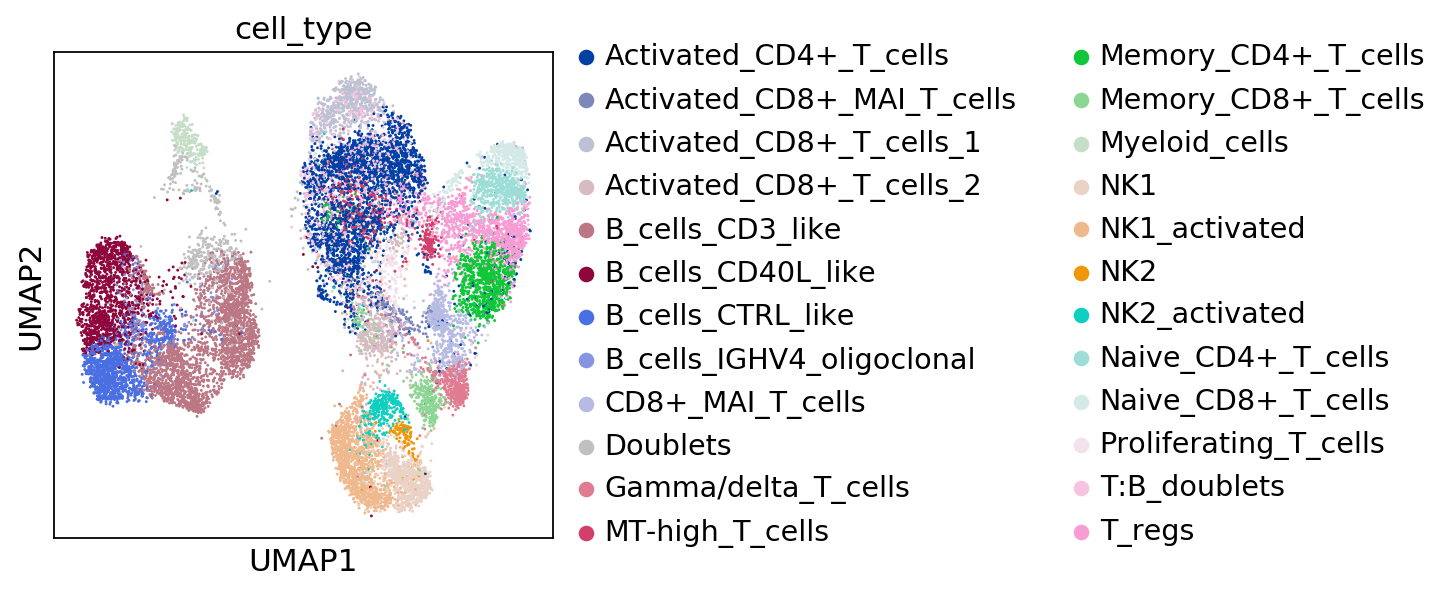

In [6]:
sc.pl.umap(adata,color=['cell_type'])

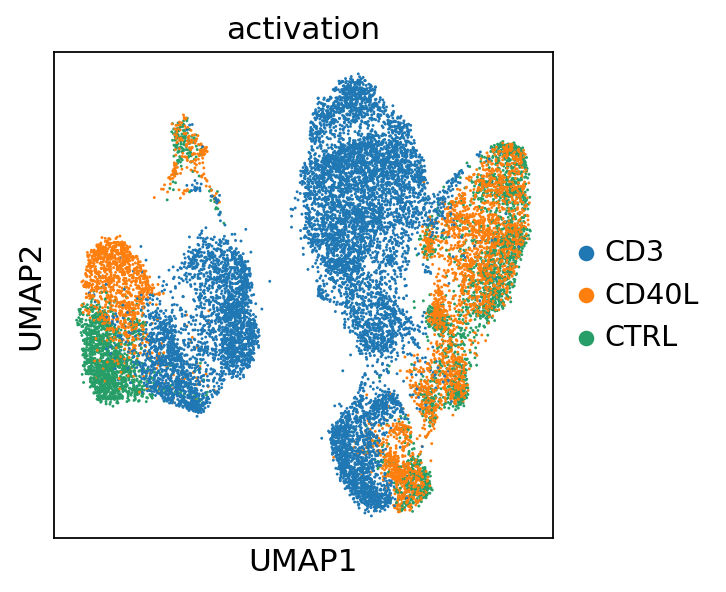

In [7]:
sc.pl.umap(adata,color=['activation'])

### Subset only B cells and remove outliars (manually)

In [8]:
adata_B = adata[(adata.obs['cell_type'] == 'B_cells_CD3_like')
             | (adata.obs['cell_type'] == 'B_cells_CD40L_like')
             | (adata.obs['cell_type'] == 'B_cells_CTRL_like')
             | (adata.obs['cell_type'] == 'B_cells_IGHV4_oligoclonal')
              ]

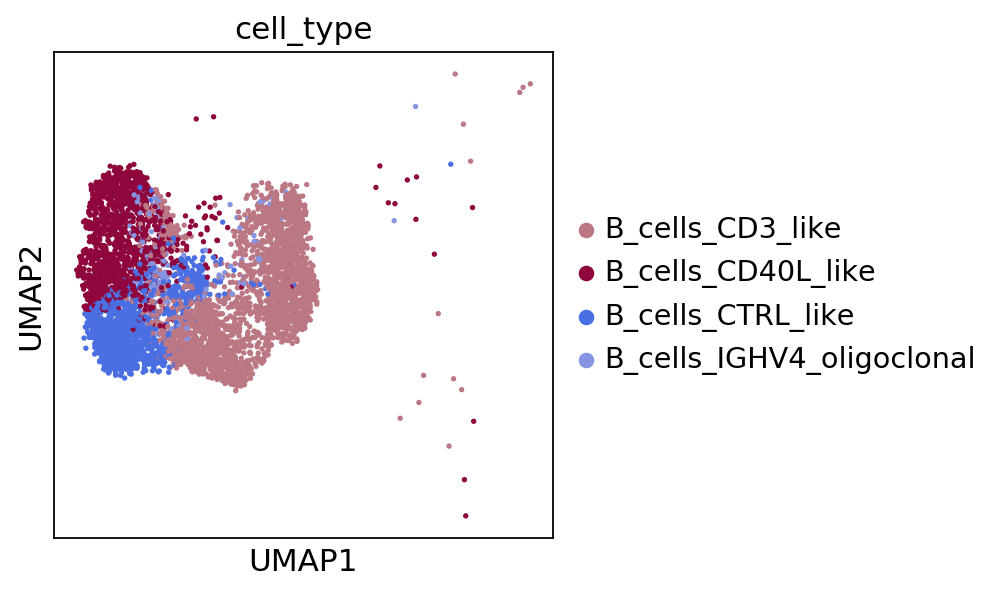

In [9]:
sc.pl.umap(adata_B,color=['cell_type'])

#### Removing outliar cells (manually)

In [10]:
x = []
y = []
for i in range(len(adata_B.obs)):
    x.append(adata_B.obsm['X_umap'][i][0])
    y.append(adata_B.obsm['X_umap'][i][1])

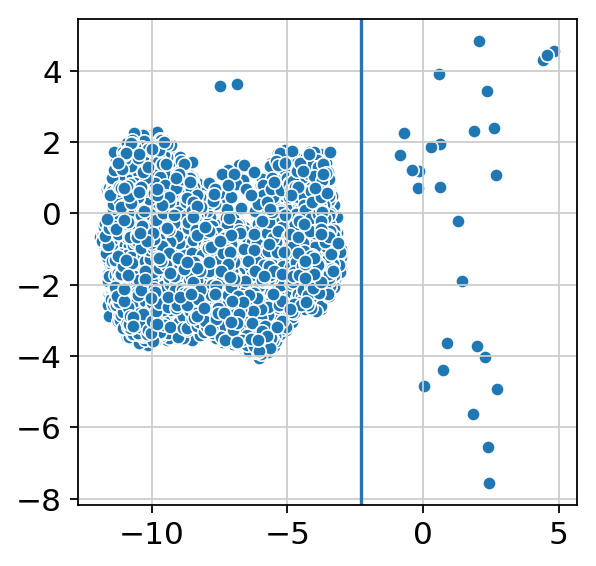

In [11]:
sns.scatterplot(x,y)
import matplotlib.pyplot as plt

plt.axvline(x=-2.3)

In [12]:
x = []
y = []
drop_list = []
keep_list_indices = []
for i in range(len(adata_B.obs)):
    if adata_B.obsm['X_umap'][i][0] <= -2.3:
        x.append(adata_B.obsm['X_umap'][i][0])
        y.append(adata_B.obsm['X_umap'][i][1])
        keep_list_indices.append(i)
    else:
        drop_list.append(adata_B.obs.index[i])

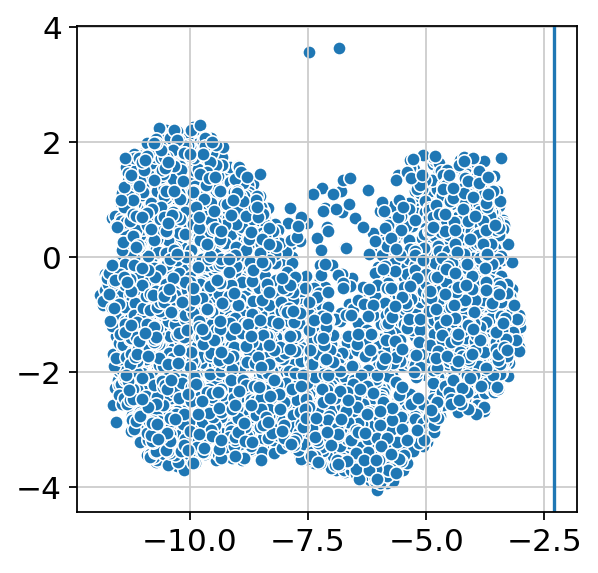

In [13]:
sns.scatterplot(x,y)
import matplotlib.pyplot as plt

plt.axvline(x=-2.3)

In [14]:
adata_B = adata_B[keep_list_indices, :]

In [15]:
adata_B

View of AnnData object with n_obs × n_vars = 5123 × 4045 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'myel_refine'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_ty

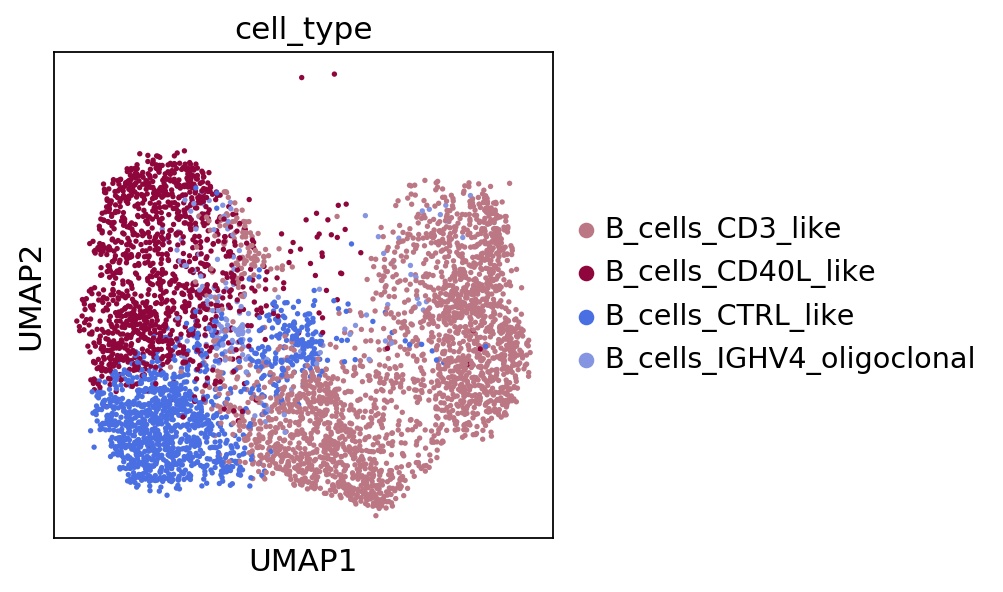

In [16]:
sc.pl.umap(adata_B, color=['cell_type'])

### Reanalysing this subset
- taking the raw attribute
- filtering cell cycle genes
- subsetting to HVGs
- scaling
- pca
- neighbors - BBKNN by seq_batch
- umap

In [53]:
adata_B_full = anndata.AnnData(X=adata_B.raw.X, # normalised and log transformed, not scaled
                            obs=adata_B.obs,
                            var=adata_B.raw.var,
                            obsm=adata_B.obsm)
adata_B_full.raw = adata_B_full.copy()

In [54]:
cellcycle_adata = adata_B_full.copy()

In [55]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
#cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]

In [56]:
cellcycle_adata.obs.index

Index(['RP11-34P13.7', 'FO538757.3', 'FO538757.2', 'AP006222.2',
       'RP5-857K21.4', 'RP11-206L10.9', 'LINC00115', 'FAM41C', 'NOC2L',
       'KLHL17',
       ...
       'RP11-473I1.6', 'LINC00310', 'HCG22', 'RP1-167O22.1', 'OR2T10',
       'XXbac-BPGBPG55C20.3', 'RP13-735L24.1', 'CDH2', 'HPD', 'PMEL'],
      dtype='object', name='index', length=17976)

In [57]:
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:12)


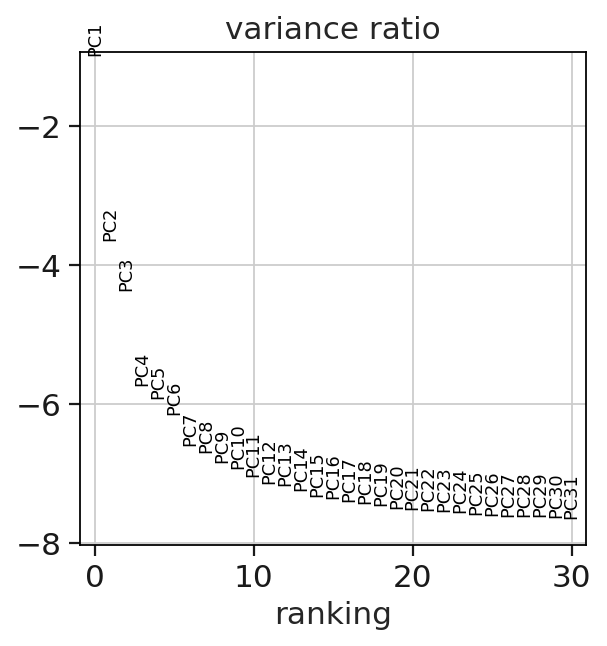

In [58]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

In [59]:
'CDK1' in list(cellcycle_adata.obs_names) 

True

In [60]:
'MKI67' in list(cellcycle_adata.obs_names)

True

In [61]:
'CCNB2' in list(cellcycle_adata.obs_names)

True

In [62]:
'PCNA' in list(cellcycle_adata.obs_names)

True

In [63]:
# Identify genes behaving like cc genes
num_pcs = 20
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


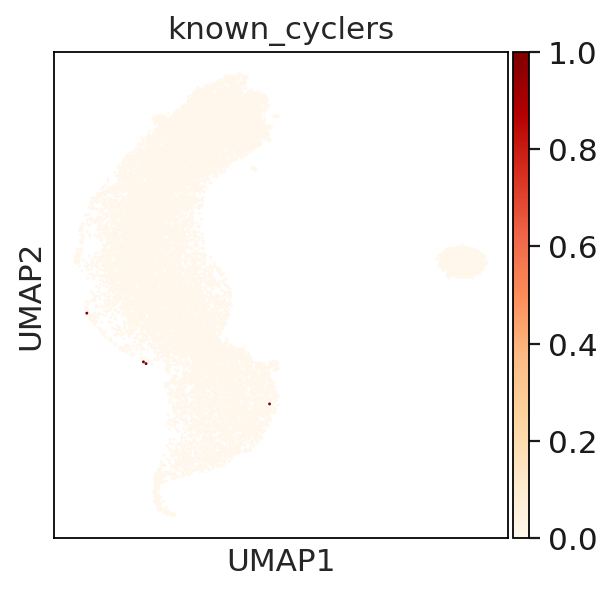

In [64]:
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


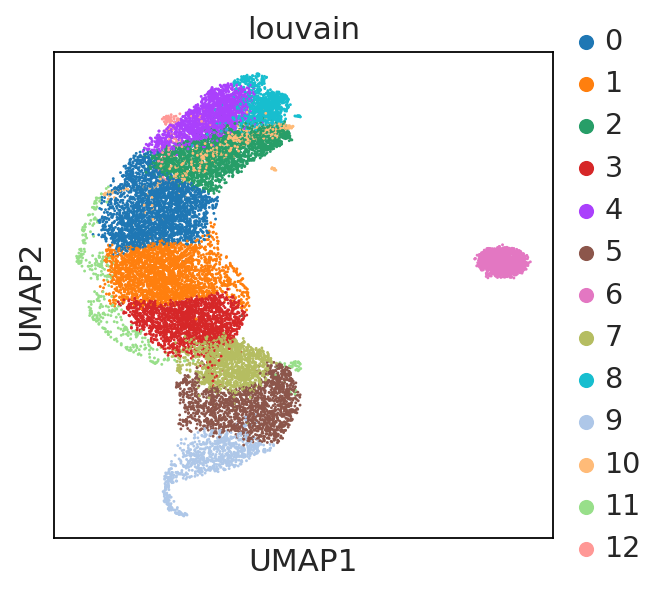

In [65]:
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(cellcycle_adata, resolution=1)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
sc.pl.umap(cellcycle_adata, color=['louvain'])

In [66]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67','CCNB2','PCNA'],'louvain'])


index
CDK1     11
MKI67    11
CCNB2    11
PCNA      5
Name: louvain, dtype: category
Categories (13, object): [0, 1, 2, 3, ..., 9, 10, 11, 12]


In [67]:
# Add unstructured dict-like annotation for ccgs
adata_B_full.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='5') & (cellcycle_adata.obs['louvain']=='11')].index)

# Remove cc genes
adata_B_full = adata_B_full[:,[i not in adata_B_full.uns['ccgs'] for i in adata_B_full.var_names]]

### Subsetting to highly variable genes

In [68]:
%%time
sc.pp.highly_variable_genes(adata_B_full, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trying to set attribute `.var` of view, making a copy.


CPU times: user 1.45 s, sys: 128 ms, total: 1.58 s
Wall time: 1.58 s


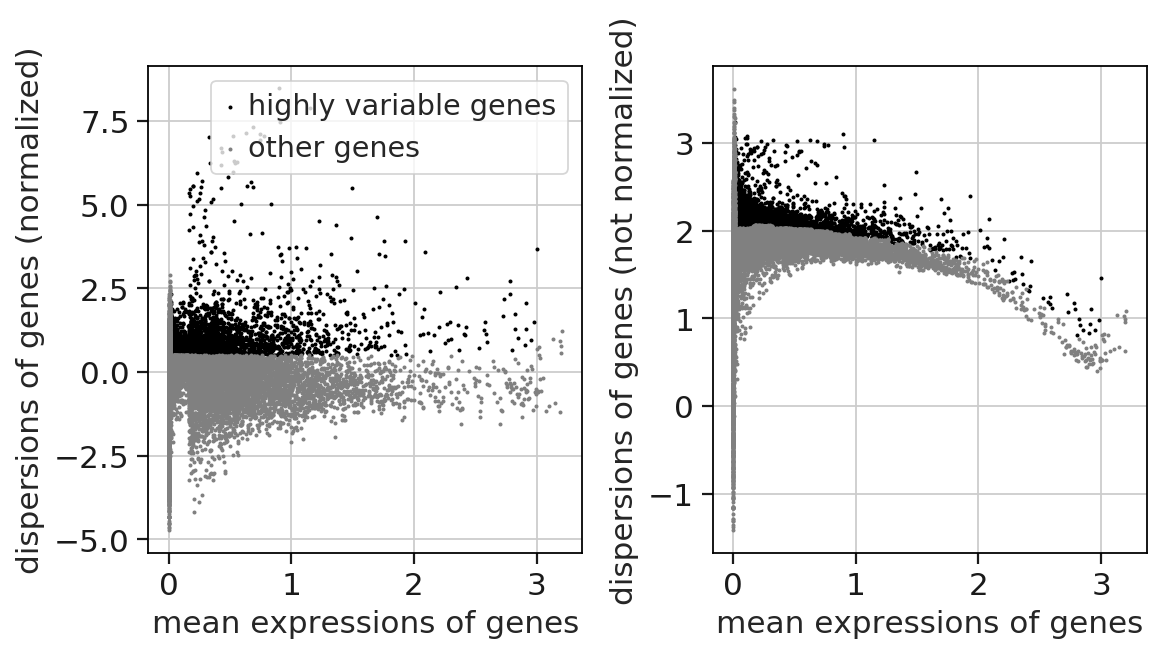

CPU times: user 1.22 s, sys: 768 ms, total: 1.99 s
Wall time: 1 s


In [69]:
%%time
sc.pl.highly_variable_genes(adata_B_full)

In [70]:
adata_B_hvg = adata_B_full[:, adata_B_full.var['highly_variable']]

In [71]:
adata_B_hvg

View of AnnData object with n_obs × n_vars = 5146 × 3612 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_types-3', 'genome

In [72]:
%%time
sc.pp.scale(adata_B_hvg, max_value=10)

CPU times: user 152 ms, sys: 176 ms, total: 328 ms
Wall time: 329 ms


_______________________________________________________________________________________________________________________

In [73]:
%%time
sc.tl.pca(adata_B_hvg, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
CPU times: user 16.8 s, sys: 24.8 s, total: 41.6 s
Wall time: 3.09 s


_______________________________________________________________________________________________________________________

In [74]:
%%time
# bbknn by batch (here batch is condition+treatment)
bbknn.bbknn(adata_B_hvg, batch_key='seq_batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 497 ms


__________________________________________________________________________________________________________________________________________________________________

In [75]:
%%time
sc.tl.umap(adata_B_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
CPU times: user 13.8 s, sys: 3.24 s, total: 17 s
Wall time: 12.5 s


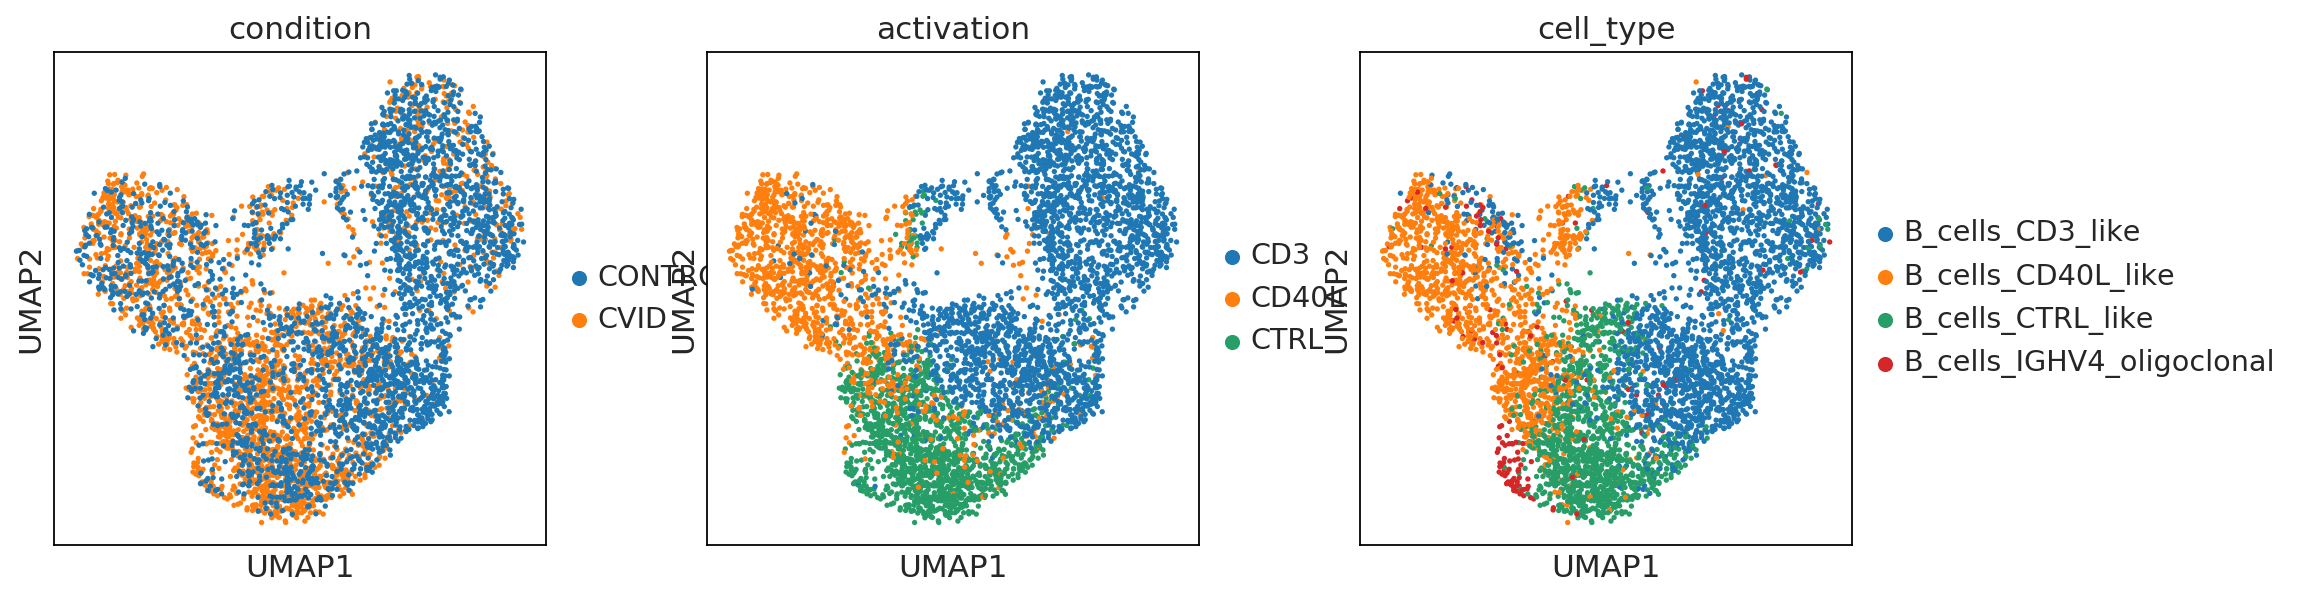

In [80]:
# after removing cell cycle genes
sc.pl.umap(adata_B_hvg, color=['condition', 'activation','cell_type'], use_raw=True, cmap='OrRd')

In [19]:
adata_B_hvg.write('./adata_B_cells_reanalysed.h5ad')

In [20]:
adata_B_hvg = sc.read('./adata_B_cells_reanalysed.h5ad')